In [1]:
%matplotlib inline

In [2]:
import geopandas as gp, pandas as pd, numpy as np

In [3]:
x = gp.GeoDataFrame.from_file('/Users/nicolas/workspace/mtlelection2013bysection/sectionelect.json')

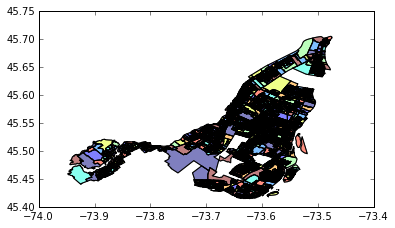

In [4]:
x.plot()

In [5]:
x["district_id"] = x.NOM_DISTRICT.apply(lambda x: int(x))
x["section_id"] = x.NOM_SECTION.apply(lambda x: int(x.split("-")[1]))
x["xcoord"] = x.centroid.apply(lambda x: x.x)
x["ycoord"] = x.centroid.apply(lambda x: x.y)

In [6]:
elec = pd.read_csv("/Users/nicolas/workspace/mtlelection2013bydistrict/elections-2013-resultats-detailles.csv")

In [7]:
import unicodedata

def to_ascii(input_str):
    if isinstance(input_str, str):
        input_str = input_str.decode('utf-8')
    elif not isinstance(input_str, unicode):
        input_str = str(input_str).decode('utf-8')
    nkfd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nkfd_form.encode('ASCII', 'ignore')
    return only_ascii

elec.District = elec.District.apply(to_ascii)
elec.Candidat = elec.Candidat.apply(to_ascii)

In [8]:
def merge_candidate(c):
    if c in ["CODERRE Denis", "BERGERON Richard"]: return c
    if c == "JOLY Melanie": return "JOLY Mélanie"
    if c == "CTE Marcel": return "CÔTÉ Marcel"
    return "Other"

elec["Candidate"] = elec.Candidat.apply(merge_candidate)

In [9]:
elec["district_id"] = elec.District.apply(lambda x: int(x.split("-")[0]))
def to_section_id(x):
    try:
        return int(x)
    except:
        return -1
elec["section_id"] = elec.Bureau.apply(to_section_id)

In [10]:
boroughs = {
    1: "Ahuntsic-Cartierville",
    2: "Anjou",
    3: "Côte-des-Neiges–Notre-Dame-de-Grâce",
    4: "Lachine",
    5: "LaSalle",
    6: "L’Île-Bizard–Sainte-Geneviève",
    7: "Mercier–Hochelaga-Maisonneuve",
    8: "Montréal-Nord",
    9: "Outremont",
    10: "Pierrefonds-Roxboro",
    11: "Plateau-Mont-Royal",
    12: "Rivière-des-Prairies–Pointe-aux-Trembles",
    13: "Rosemont–La Petite-Patrie",
    14: "Saint-Laurent",
    15: "Saint-Léonard",
    16: "Sud-Ouest",
    17: "Verdun",
    18: "Ville-Marie",
    19: "Villeray–Saint-Michel–Parc-Extension"
}
elec["Borough"] = elec.district_id.apply(lambda x: boroughs[int(x/10)])

In [11]:
districts = {
    11 : "Sault-au-Récollet",
    12 : "Saint-Sulpice",
    13 : "Ahuntsic",
    14 : "Bordeaux-Cartierville",
    21 : "Ouest",
    22 : "Est",
    23 : "Centre",
    31 : "Darlington",
    32 : "Côte-des-Neiges",
    33 : "Snowdon",
    34 : "Notre-Dame-de-Grâce",
    35 : "Loyola",
    41 : "du Canal",
    42 : "J.-Émery-Provost",
    43 : "Fort-Rolland",
    51 : "Sault-Saint-Louis",
    52 : "Cecil-P.-Newman",
    61 : "Pierre-Foretier",
    62 : "Denis-Benjamin-Viger",
    63 : "Jacques-Bizard",
    64 : "Sainte-Geneviève",
    71 : "Tétreaultville",
    72 : "Maisonneuve–Longue-Pointe",
    73 : "Hochelaga",
    74 : "Louis-Riel",
    81 : "Marie-Clarac",
    82 : "Ovide-Clermont",
    91 : "Claude-Ryan",
    92 : "Joseph-Beaubien",
    93 : "Robert-Bourassa",
    94 : "Jeanne-Sauvé",
    101: "Bois-de-Liesse",
    102: "Cap-Saint-Jacques",
    111: "Mile-End",
    112: "DeLorimier",
    113: "Jeanne-Mance",
    121: "La Pointe-aux-Prairies",
    122: "Pointe-aux-Trembles",
    123: "Rivière-des-Prairies",
    131: "Saint-Édouard",
    132: "Étienne-Desmarteau",
    133: "Vieux-Rosemont",
    134: "Marie-Victorin",
    141: "Côte-de-Liesse",
    142: "Norman-McLaren",
    151: "Saint-Léonard-Est",
    152: "Saint-Léonard-Ouest",
    161: "Saint-Henri–Petite-Bourgogne–Pointe-Saint-Charles",
    162: "Saint-Paul–Émard",
    171: "Champlain–L'Île-des-Soeurs",
    172: "Desmarchais-Crawford",
    181: "Peter-McGill",
    182: "Saint-Jacques",
    183: "Sainte-Marie",
    191: "Saint-Michel",
    192: "François-Perrault",
    193: "Villeray",
    194: "Parc-Extension"
}
elec["District"] = elec.district_id.apply(lambda x: districts[x])

In [12]:
elec.query("Poste == '0'").pivot_table(
    columns="Candidate", index=['district_id','section_id','Borough','District'], 
    values="Votes", aggfunc="sum"
).reset_index().merge(
    x[["xcoord", "ycoord","district_id","section_id"]], 
    left_on=["district_id","section_id"], 
    right_on=["district_id","section_id"]
).fillna(0).to_json("/Users/nicolas/workspace/mtlelectionpies/election_section.json", orient="records")